In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from supporting import tune_knn_regression, remove_outliers_y, assign_val_data_to_clusters_with_labels,assign_test_data_to_clusters_with_labels, tune_ridge_regression, plot_clusters_features_vs_target, divide_data_by_kmeans_distance, remove_outliers, standardize_data, create_polynomial_features, apply_pca, rmse, tune_kernel_ridge_regression, tune_gaussian_process_regression

In [4]:
# importing the data
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:,:-1]
y = training_data[:,-1]

From further observations we found that the data has many outliers (particularly in cluster 1).

Because of this, depending on whether the outliers are in the training or test data, we get very different RMSE results.
Since we have no information about whether these outliers should be kept or not, we decided to remove them.

The way we remove them is by removing the observations of the y values based on the 1.5 * IQR.

In [44]:
X_no, y_no = remove_outliers_y(X, y, 7)

19


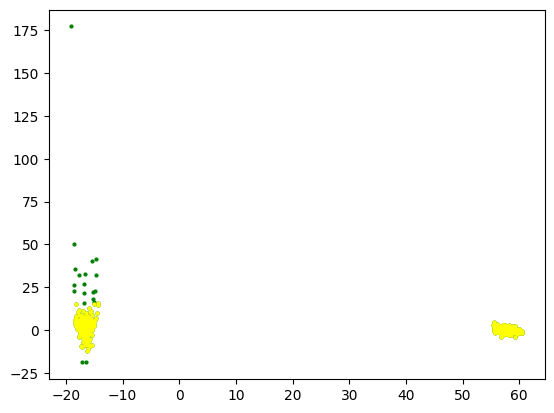

In [45]:
plt.scatter(X[:, 2], y, color = 'green', s = 4)
plt.scatter(X_no[:, 2], y_no, color = 'yellow', s = 4)

From this graph, we see that if we use the whole dataset to remove outliers, we have many more outliers in one of the clusters. Therefore, we decided to first split the data into the clusters and then remove outliers but only from cluster 1.

## Taking a look at the Data

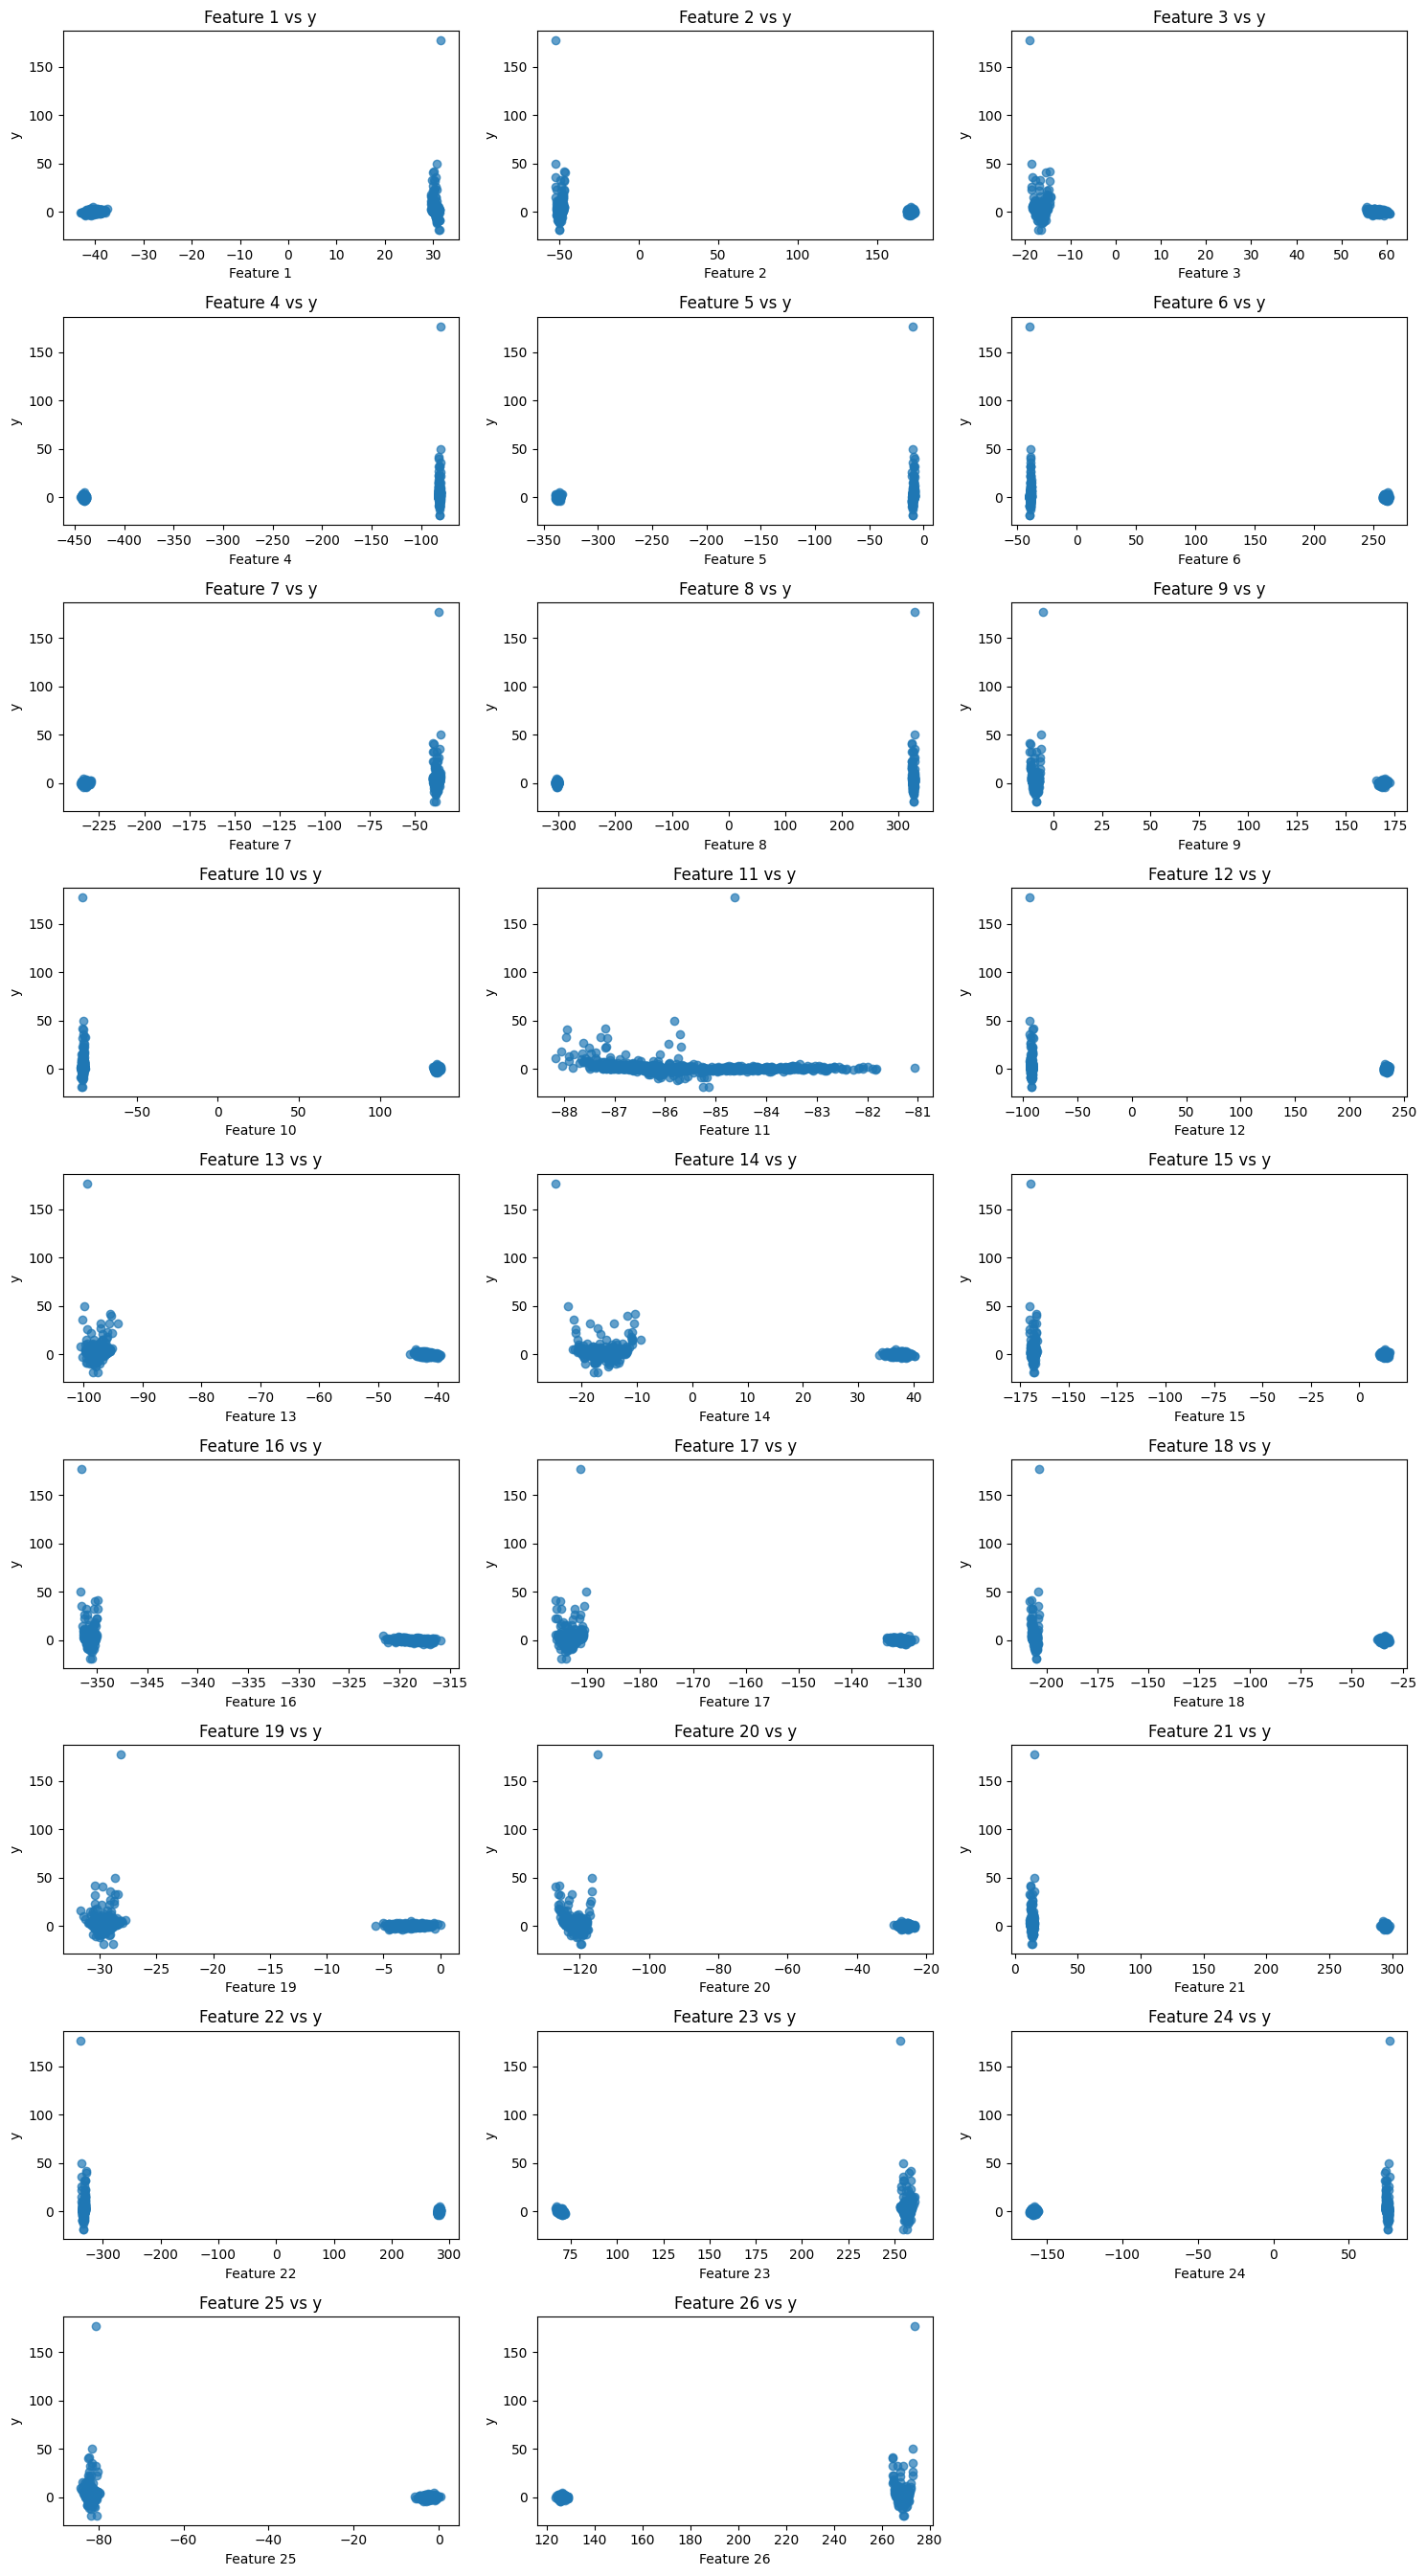

In [7]:
n_features = X.shape[1]
n_rows = np.ceil(n_features / 3).astype(int)  # Determine number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))  # 3 subplots per row
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Plot each feature against y
for i in range(n_features):
    axes[i].scatter(X[:, i], y, alpha=0.7)
    axes[i].set_title(f'Feature {i + 1} vs y')
    axes[i].set_xlabel(f'Feature {i + 1}')
    axes[i].set_ylabel('y')

# Remove any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From how the data is visualised, we can see that there are to different distributions of points in our dataset.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

## Correctly assigning points to each distribution

We do this by applying kmeans. Even though we can see from the training data that there is two distributions, we wanted to make the model more robust, because if the training data changes or is updated, then the model could start having issues.

Here we are simply testing that even with outliers, the model can correctly classify the points into the two clusters.

In [9]:
# Dividing the training data into two clusters given that it looks like the data comes from two different distributions

(X_train_clusters, y_train_clusters), clusters, labels = divide_data_by_kmeans_distance(
    x_train, y_train, n_clusters=2
)

X1_train, y1_train = X_train_clusters[0], y_train_clusters[0]
X2_train, y2_train = X_train_clusters[1], y_train_clusters[1]

# Calculate the mean of the second feature for each cluster
cluster_0_mean = clusters[0][1]
cluster_1_mean = clusters[1][1]

# This condition was only inseted to make sure that there was no issue in labels' assignment
# Ensure that cluster 1 has a mean of the second feature below 61 and cluster 2 above 61
if cluster_0_mean < 61 and cluster_1_mean > 61:
    print('No need to switch')
    # Cluster 0 is correct for averaging, Cluster 1 for Bayesian
    X1_train, y1_train = X_train_clusters[0], y_train_clusters[0]
    X2_train, y2_train = X_train_clusters[1], y_train_clusters[1]
elif cluster_1_mean < 61 and cluster_0_mean > 61:
    print('Had to switch')
    # Cluster 1 should be assigned to averaging, Cluster 0 to Bayesian
    X1_train, y1_train = X_train_clusters[1], y_train_clusters[1]
    X2_train, y2_train = X_train_clusters[0], y_train_clusters[0]
    labels = [1, 0]

# Using the means of the two clusters to determine which cluster each datapoint of the test data belongs to
X1_test, y1_test, X2_test, y2_test = assign_val_data_to_clusters_with_labels(x_test, y_test, clusters, labels)

No need to switch


### Checking if clusters have are balanced in terms of number of observations

In [10]:
print(f'Training length of Cluster 0: {len(X1_train)} \nTraining Length of Cluster 1: {len(X2_train)} \nTest length of Cluster 0: {len(X1_test)} \nTest length of Cluster1: {len(X2_test)}')

Training length of Cluster 0: 351 
Training Length of Cluster 1: 249 
Test length of Cluster 0: 122 
Test length of Cluster1: 78


## Visualising the train and test data clusters to make sure they were correctly classified

This is useful for testing purposes only.

We can change the number of the features X to show the comparison between different features

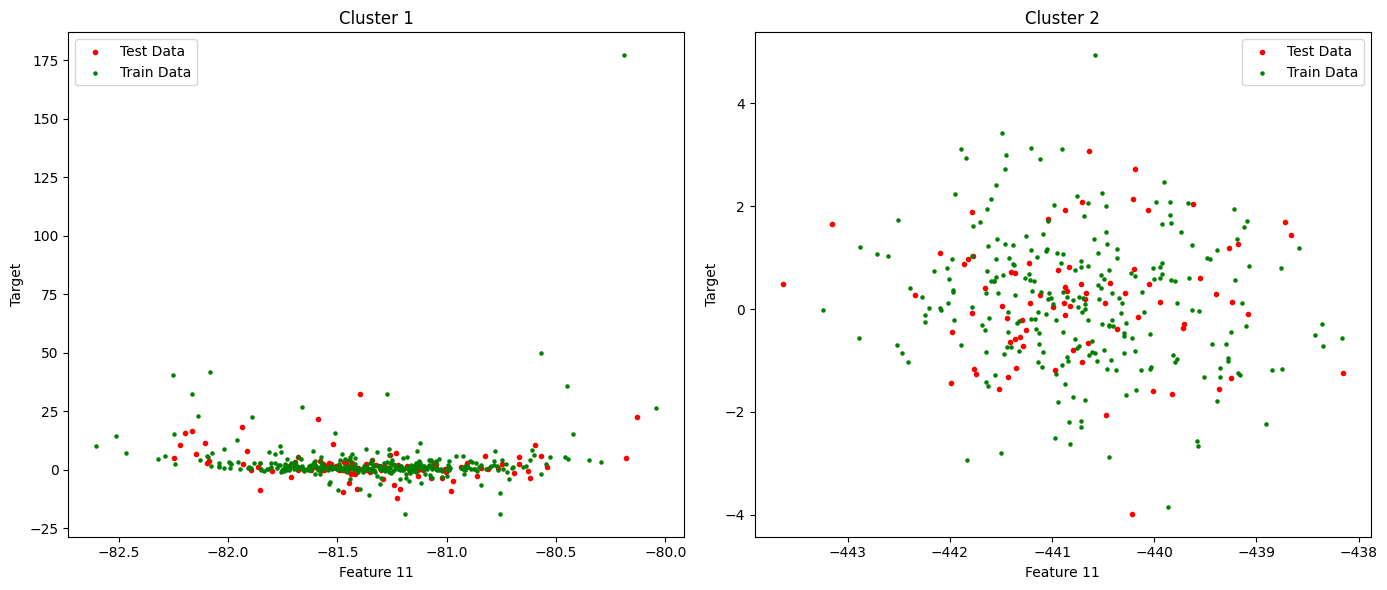

In [11]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# changing this value will change the X feature plotted
x_feature = 3

# First subplot for Cluster 1
axes[0].scatter(X1_test[:, x_feature], y1_test, color='red', label='Test Data', s = 9)
axes[0].scatter(X1_train[:, x_feature], y1_train, color='green', label='Train Data', s = 5)
axes[0].set_title('Cluster 1')
axes[0].set_xlabel('Feature 11')
axes[0].set_ylabel('Target')
axes[0].legend()

# Second subplot for Cluster 2
axes[1].scatter(X2_test[:, x_feature], y2_test, color='red', label='Test Data', s = 9)
axes[1].scatter(X2_train[:, x_feature], y2_train, color='green', label='Train Data', s = 5)
axes[1].set_title('Cluster 2')
axes[1].set_xlabel('Feature 11')
axes[1].set_ylabel('Target')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


This plot shows only one division of the train test split, however, for cluster 1 when we want to fine-tune our models, we want to consider different splits of the train-test data.

Additionally, from these graphs, we can see that:
- cluster 2 does not have many outliers
- cluster 1 has a bit of outliers

## Taking a look at the data based on the cluster labels

Here below we check if our assumption of having two distributions in the dataset could be correct by plotting the data colored using the cluster means. If there is a pefect separation between the two clusters, we will assume tha there are two distributions in the dataset.

This shows better plots when the data used doesn't have outliers (to do this, go to the outliers removal step and follow the steps, then rerun this cell).

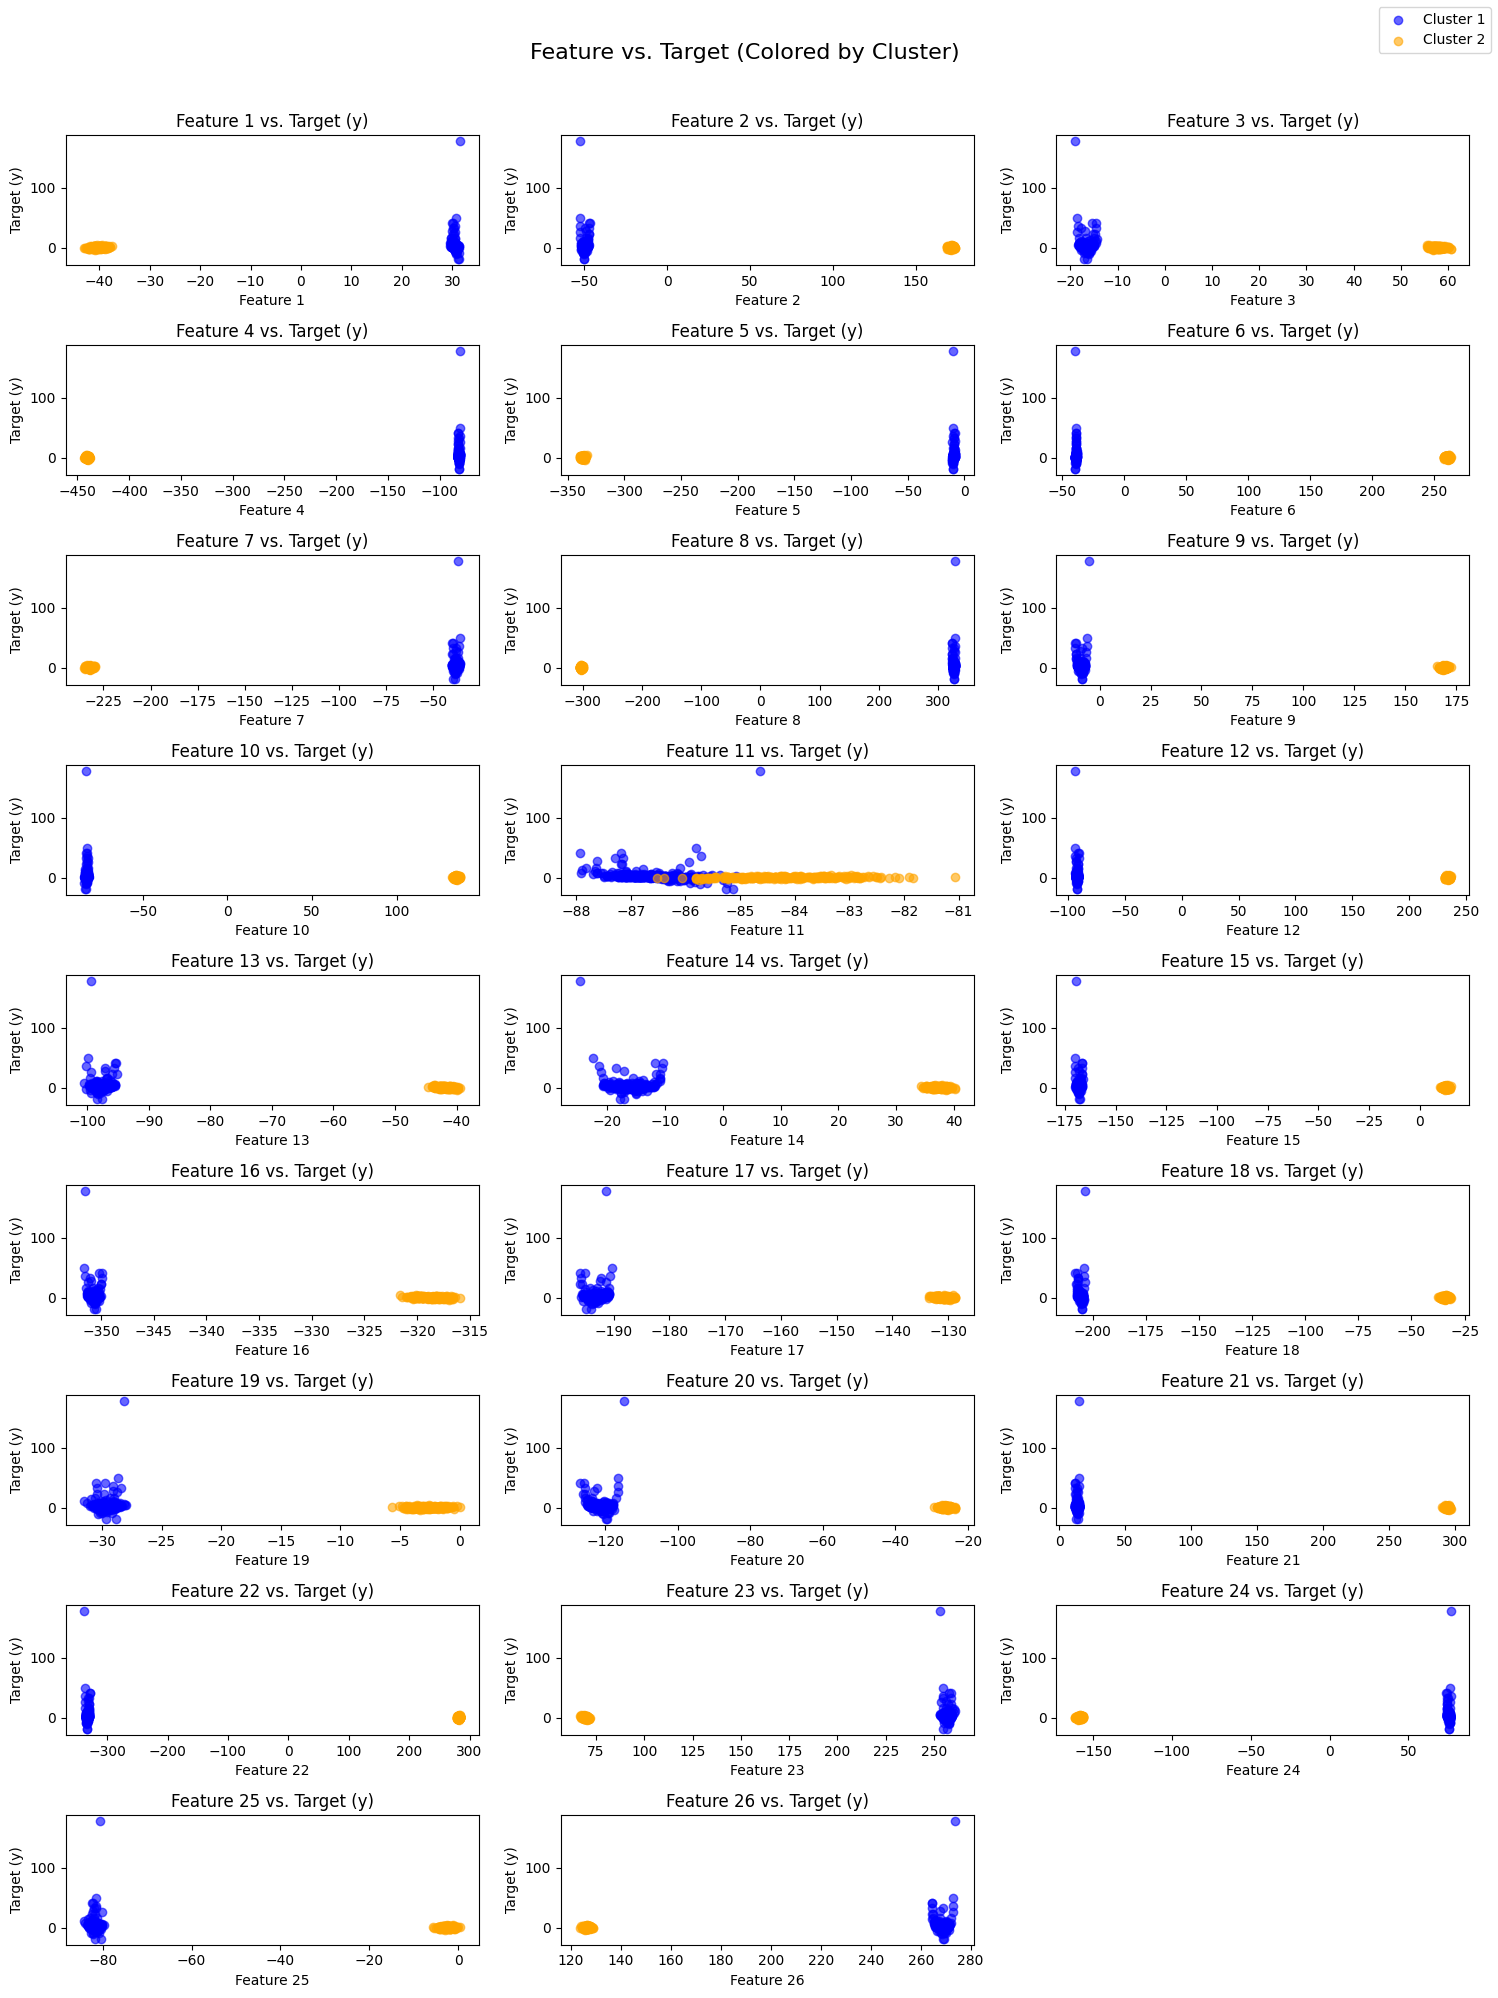

In [12]:
plot_clusters_features_vs_target(X_train_clusters, y_train_clusters, n_cols=3, figsize=(15, 20))

## Considering The Ball Shaped Cluster

Important: it is possible that the clustering algorithm changes the label of the cluster resulting in a switch between points in cluster 0 and 1. For this reason, please make sure that the clustering algorithm classifies correctly. Logic to do this has beeen implemented when doing the training split. However, the numbers used are based on our analysis and may change if x_train increases, since they are a simple estimate.

We assume Normal distribution of the data and apply the BayesianRidge model on the data which results in very accurate predictions.

Also, we saw that this training data does not have any outliers for the values of y, therefore we don't have to remove any.

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# Create the polynomial features
# X2_train_poly, X2_test_poly = create_polynomial_features(X2_train, X2_test, degree = 5)

# Create the KNN Regressor model
model = BayesianRidge()

# Fit the model to the training data
model.fit(X2_train, y2_train)

y_pred_train = model.predict(X2_train)

# Make predictions on the test data
y_pred = model.predict(X2_test)

# Calculate the RMSE
rmse_value = rmse(y2_test, y_pred)

print(f'Training RMSE: {rmse(y2_train, y_pred_train)}')

print(f'Test RMSE: {rmse_value}')



Training RMSE: 7.821032888222293e-10
Test RMSE: 8.541915587545012e-10


Here, we didn't create a split to fine-tune this model because already on the default settings it was performing extremely well.

We can see that the Traning and Test RMSEs are close together and very small.

## Considering the Line Shaped Cluster

Here, we first need to remove the outliers from both the training and test data for cluster 2.

We tested both removing all the outliers above 1.5 and only the outlier with y > 150 and we decided to only remove the outlier of more than 150 from the data.

Then, we create multiple possibilities of X:
- standardised, using Standard Scaler
- pca
- poly, which was done both on original and scaled data (just replacing the x1_train(test)_scaled data with x1_train(test))

In [20]:
X1 = np.vstack((X1_train, X1_test))
y1 = np.concatenate((y1_train, y1_test))


print('Number of removed outliers:')
X1_no, y1_no = remove_outliers_y(X1, y1, 7)
#X1_no, y1_no = X1, y1

print('Percentage of removed outliers: ')
print((len(X1) - len(X1_no)) / len(X1))

Number of removed outliers:
16
Percentage of removed outliers: 
0.03382663847780127


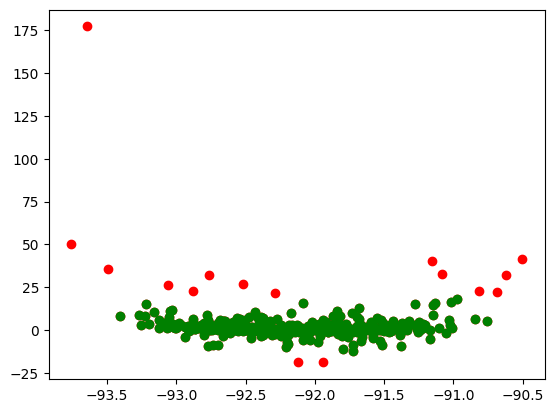

In [21]:
plt.scatter(X1[:, 11], y1, color = 'red')
plt.scatter(X1_no[:, 11], y1_no, color = 'green')

In [22]:
x1_train_no, x1_test_no, y1_train_no, y1_test_no = train_test_split(X1_no, y1_no)
x1_train_no, x1_val_no, y1_train_no, y1_val_no = train_test_split(x1_train_no, y1_train_no)

In [23]:
x1_train_scaled, x1_val_scaled = standardize_data(x1_train_no, x1_val_no)
x1_train_pca, x1_val_pca = apply_pca(x1_train_no, x1_val_no, 0.95)
x1_train_poly_scaled, x1_val_poly_scaled = create_polynomial_features(x1_train_scaled, x1_val_scaled, 3)
x1_train_poly, x1_val_poly = create_polynomial_features(x1_train_no, x1_val_no, 3)
x1_train_poly_pca, x1_val_poly_pca = create_polynomial_features(x1_train_pca, x1_val_pca)

Fine-tuning the models

In [24]:
# checking best params based on grid search training and validation tests
best_model_gr, best_params_gr, grid_search_gr, y_pred_gr = tune_gaussian_process_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_gr))

(256, 3) (86, 3)


/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/sit

1.447293340533897


In [25]:
x1_test_pca, _ = apply_pca(x1_test_no, x1_test_no, 0.95)
x1_test_pca = x1_test_pca[:, [0, 1, 2]]

y_pred_gr = best_model_gr.predict(x1_test_pca)

rmse(y1_test_no, y_pred_gr)

3.4003496527745973

In [26]:
best_model_r, best_params_r, grid_search_r, y_pred_r = tune_ridge_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_r))

Fitting 15 folds for each of 5 candidates, totalling 75 fits
2.916273545343128


In [27]:
y_pred_r = best_model_r.predict(x1_test_pca)

rmse(y1_test_no, y_pred_r)

4.171450114852523

In [28]:
best_model_kr, best_params_kr, grid_search_kr, y_pred_kr = tune_kernel_ridge_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_kr))

(256, 3) (86, 3)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution i

1.1522088856138684


/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/paolocadei/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution i

In [29]:
y_pred_kr = best_model_kr.predict(x1_test_pca)

rmse(y1_test_no, y_pred_r)

4.171450114852523

In [30]:
best_model_knn, best_params_knn, grid_search_knn, y_pred_knn = tune_knn_regression(x1_train_pca, y1_train_no, x1_val_pca)
print(rmse(y1_val_no, y_pred_knn))

(256, 3) (86, 3)
1.6182142199706653


In [31]:
y_pred_knn = best_model_knn.predict(x1_test_pca)

rmse(y1_test_no, y_pred_knn)

3.459331955512718

In [32]:
print(f'Best Params Gaussian Regression: {best_params_gr}')
print(f'Best Params Ridge: {best_params_r}')
print(f'Best Params Kernel Regression: {best_model_kr}')
print(f'Best Params KNN Regression: {best_params_knn}')

Best Params Gaussian Regression: {'alpha': 0.01, 'kernel': RationalQuadratic(alpha=0.1, length_scale=10)}
Best Params Ridge: {'alpha': 0}
Best Params Kernel Regression: KernelRidge(alpha=10.0, degree=4, kernel='poly')
Best Params KNN Regression: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


Now, we will use the following results to calculate an averaging model

In [33]:
# redefine the training and test data to use all data available

x1_train_no, x1_test_no, y1_train_no, y1_test_no = train_test_split(X1_no, y1_no)

x1_train_pca, x1_test_pca = apply_pca(x1_train_no, x1_test_no, 0.95)

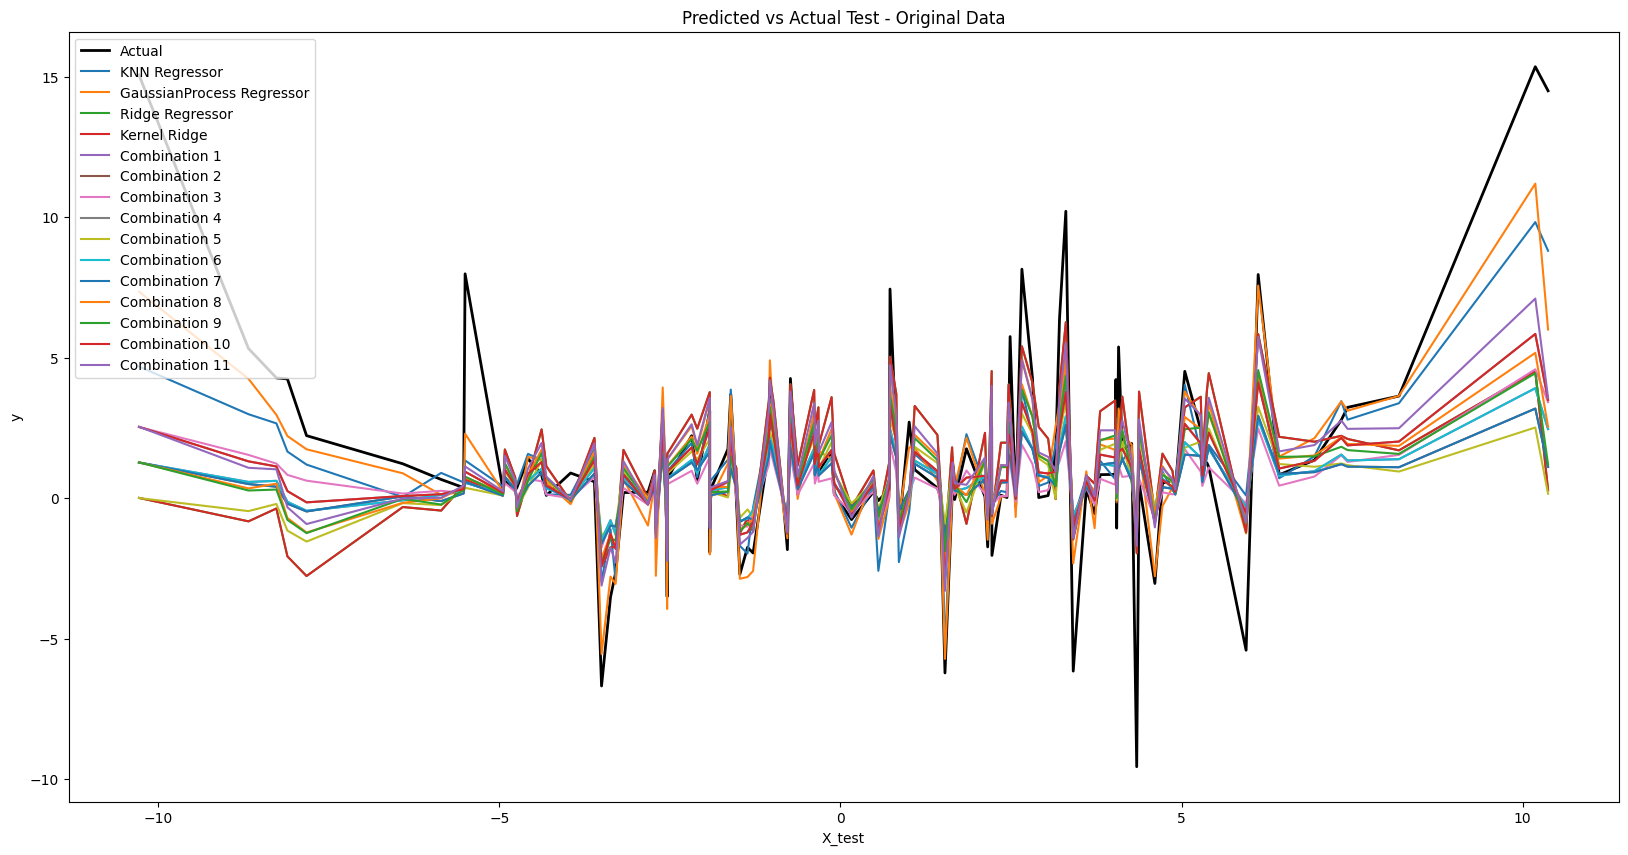

In [50]:
# Function to train, evaluate models, calculate weighted combination RMSE, and return predicted values
def evaluate_models_with_combinations(X1_train, X1_test, y1_train, y1_test, dataset_name):
    results = []
    predicted_y_values = {'train': {}, 'test': {}}

    # --- KNN Regressor ---
    model_knr = KNeighborsRegressor(n_neighbors=10, metric = 'manhattan', weights = 'distance')
    model_knr.fit(X1_train, y1_train)
    y_pred_train_knr = model_knr.predict(X1_train)
    y_pred_knr = model_knr.predict(X1_test)
    results.append([dataset_name, 'KNN Regressor', rmse(y1_train, y_pred_train_knr), rmse(y1_test, y_pred_knr)])
    predicted_y_values['train']['KNN Regressor'] = y_pred_train_knr
    predicted_y_values['test']['KNN Regressor'] = y_pred_knr

    # --- Gaussian Process Regressor ---
    model_gpr = GaussianProcessRegressor(alpha=0.01, kernel=RationalQuadratic(alpha=0.1, length_scale=10))
    model_gpr.fit(X1_train, y1_train)
    y_pred_train_g = model_gpr.predict(X1_train)
    y_pred_g = model_gpr.predict(X1_test)
    results.append([dataset_name, 'GaussianProcess Regressor', rmse(y1_train, y_pred_train_g), rmse(y1_test, y_pred_g)])
    predicted_y_values['train']['GaussianProcess Regressor'] = y_pred_train_g
    predicted_y_values['test']['GaussianProcess Regressor'] = y_pred_g

    # --- Ridge Regressor ---
    model_ridge = Ridge(alpha=100)
    model_ridge.fit(X1_train, y1_train)
    y_pred_train_r = model_ridge.predict(X1_train)
    y_pred_r = model_ridge.predict(X1_test)
    results.append([dataset_name, 'Ridge Regressor', rmse(y1_train, y_pred_train_r), rmse(y1_test, y_pred_r)])
    predicted_y_values['train']['Ridge Regressor'] = y_pred_train_r
    predicted_y_values['test']['Ridge Regressor'] = y_pred_r

    model_kr = KernelRidge(alpha=10, degree = 2, kernel = 'poly')
    model_kr.fit(X1_train, y1_train)
    y_pred_train_kr = model_ridge.predict(X1_train)
    y_pred_kr = model_ridge.predict(X1_test)
    results.append([dataset_name, 'Kernel Ridge', rmse(y1_train, y_pred_train_kr), rmse(y1_test, y_pred_kr)])
    predicted_y_values['train']['Kernel Ridge'] = y_pred_train_kr
    predicted_y_values['test']['Kernel Ridge'] = y_pred_kr

    # --- Check for NaNs in predictions ---
    if np.any(np.isnan([y_pred_r, y_pred_knr, y_pred_g, y_pred_kr])):
        print("NaN values found in predictions. Please check the models or data.")
        return results, predicted_y_values

    # --- Calculate inverse variances for weighted combination ---
    inv_var_r = 1 / np.var(y_pred_r) if np.var(y_pred_r) != 0 else 0
    inv_var_knr = 1 / np.var(y_pred_knr) if np.var(y_pred_knr) != 0 else 0
    inv_var_g = 1 / np.var(y_pred_g) if np.var(y_pred_g) != 0 else 0
    inv_var_kr = 1 / np.var(y_pred_kr) if np.var(y_pred_kr) != 0 else 0

    # Calculate weights (avoid division by zero)
    total_inv_var = inv_var_r + inv_var_knr + inv_var_g + inv_var_kr
    if total_inv_var == 0:
        return results, predicted_y_values  # No valid combination if all variances are zero

    w_r = inv_var_r / total_inv_var if inv_var_r != 0 else 0
    w_knr = inv_var_knr / total_inv_var if inv_var_knr != 0 else 0
    w_g = inv_var_g / total_inv_var if inv_var_g != 0 else 0
    w_kr = inv_var_kr / total_inv_var if inv_var_kr!= 0 else 0

    # List of combinations for the weights (ensuring they sum to 1)
    combinations = [
        (w_r, w_knr, 0, 0),          # y_pred_r and y_pred_knr, ignore y_pred_g and y_pred_kr
        (w_r, 0, w_g, 0),            # y_pred_r and y_pred_g, ignore y_pred_knr and y_pred_kr
        (0, w_knr, w_g, 0),          # y_pred_knr and y_pred_g, ignore y_pred_r and y_pred_kr
        (w_r, w_knr, w_g, 0),        # y_pred_r, y_pred_knr, and y_pred_g, ignore y_pred_kr
        (w_r, 0, 0, w_kr),           # y_pred_r and y_pred_kr, ignore y_pred_knr and y_pred_g
        (0, w_knr, 0, w_kr),         # y_pred_knr and y_pred_kr, ignore y_pred_r and y_pred_g
        (0, 0, w_g, w_kr),           # y_pred_g and y_pred_kr, ignore y_pred_r and y_pred_knr
        (w_r, w_knr, 0, w_kr),       # y_pred_r, y_pred_knr, and y_pred_kr, ignore y_pred_g
        (w_r, 0, w_g, w_kr),         # y_pred_r, y_pred_g, and y_pred_kr, ignore y_pred_knr
        (0, w_knr, w_g, w_kr),       # y_pred_knr, y_pred_g, and y_pred_kr, ignore y_pred_r
        (w_r, w_knr, w_g, w_kr)      # All predictions: y_pred_r, y_pred_knr, y_pred_g, and y_pred_kr
    ]

    # Calculate RMSE for each combination (both Train and Test)
    for i, (wr, wknr, wg, wkr) in enumerate(combinations):
        # Train RMSE for combination
        y_pred_train_combined = (
            y_pred_train_r * wr + 
            y_pred_train_knr * wknr + 
            y_pred_train_g * wg + 
            y_pred_train_kr * wkr
        )
        train_rmse = rmse(y1_train, y_pred_train_combined)

        # Test RMSE for combination
        y_pred_combined = (
            y_pred_r * wr + 
            y_pred_knr * wknr + 
            y_pred_g * wg + 
            y_pred_kr * wkr
        )
        test_rmse = rmse(y1_test, y_pred_combined)

        # Append results
        results.append([dataset_name, f'Combination {i+1} (w_r={wr:.3f}, w_knr={wknr:.3f}, w_g={wg:.3f}, w_kr={wkr:.3f})', train_rmse, test_rmse])
        predicted_y_values['train'][f'Combination {i+1}'] = y_pred_train_combined
        predicted_y_values['test'][f'Combination {i+1}'] = y_pred_combined

    return results, predicted_y_values


# Collecting results for all datasets
results = []
all_predicted_y = {'train': {}, 'test': {}}
datasets = [
    ('PCA Data', x1_train_pca, x1_test_pca)
]

for dataset_name, X1_train, X1_test in datasets:
    res, pred_y = evaluate_models_with_combinations(X1_train, X1_test, y1_train_no, y1_test_no, dataset_name)
    results.extend(res)
    all_predicted_y['train'].update(pred_y['train'])
    all_predicted_y['test'].update(pred_y['test'])

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Dataset', 'Model/Combination', 'Train RMSE', 'Test RMSE'])

# Save results
results_df.to_csv('FinalResults.csv')

# Plotting function for predicted vs actual
def plot_predictions(X_test, y_test, y_pred_dict, dataset_name):
    plt.figure(figsize=(20, 10))
    
    # Sort X_test and y_test for consistent plotting
    sorted_idx = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[sorted_idx]
    y_test_sorted = y_test[sorted_idx]
    
    plt.plot(X_test_sorted[:, 0], y_test_sorted, label='Actual', color='black', linewidth=2)
    
    # Plot predictions from each model
    for model_name, y_pred in y_pred_dict.items():
        #if model_name == 'Combination 3':
            y_pred_sorted = y_pred[sorted_idx]
            plt.plot(X_test_sorted[:, 0], y_pred_sorted, label=model_name)

    plt.title(f'Predicted vs Actual Test - {dataset_name}')
    plt.xlabel('X_test')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Example: Plot predictions for the 'Original Data'
plot_predictions(x1_test_pca, y1_test_no, all_predicted_y['test'], 'Original Data')

You can use line 137 to decide which points you want to show

At the end we decide to use GaussianRegressionProcesses and KNNRegressor to obtain y_predictions that then are averaged based on their inverse variances to get the final y prediction.

For KNRegressor we realise that using weights = 'distance' overfits a lot so we decided to keep the weigths as uniform to reduce the overfitting.

This applies to cluster 1